In [1]:
!git clone https://github.com/arbit3rr/Synapse-RL.git

Cloning into 'Synapse-RL'...


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import cvxpy as cp
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

(CVXPY) Jan 28 01:07:56 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 28 01:07:56 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
grid_df = pd.read_csv('./data/grid_data.csv')
grid_df.head()

,day,solar (MW),wind (MW),load (MW),solar_forcast (MW),wind_forecast (MW),load_forecast (MW),price (EUR/MWh),emission factor (kg CO2/MWh)
0,0,0.0,5393.0,11257.0,0.0,6053.0,10783.0,0.10,73.013522
1,0,0.0,5415.0,11279.0,0.0,6037.0,10713.0,0.10,73.013522
2,0,0.0,5405.0,11291.0,0.0,6023.0,10626.0,0.10,73.013522
3,0,0.0,5411.0,11266.0,0.0,6008.0,10527.0,0.10,73.013522
4,0,0.0,5441.0,11312.0,0.0,5993.0,10457.0,0.01,73.224798


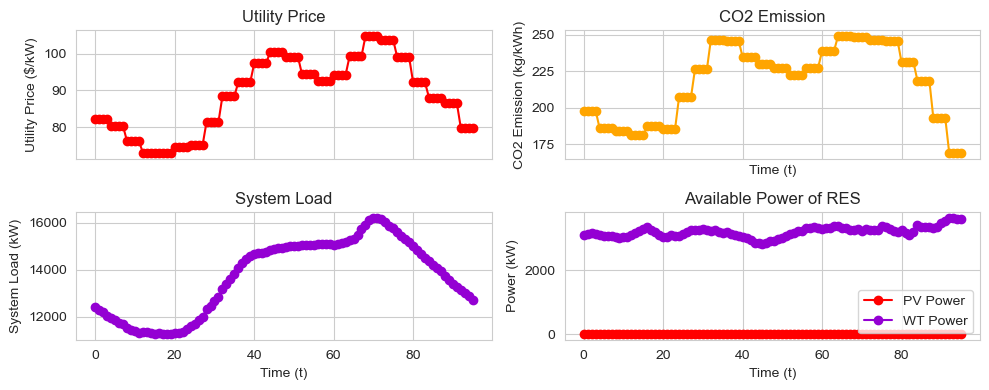

In [3]:
DAY_NUM = 5

grid_df[grid_df['day']==DAY_NUM]["emission factor (kg CO2/MWh)"].to_numpy()

pv_data = grid_df[grid_df['day']==DAY_NUM]["solar (MW)"].to_numpy()
wt_data = grid_df[grid_df['day']==DAY_NUM]["wind (MW)"].to_numpy()
price_data = grid_df[grid_df['day']==DAY_NUM]["price (EUR/MWh)"].to_numpy()
load_data = grid_df[grid_df['day']==DAY_NUM]["load (MW)"].to_numpy()
co2_data = grid_df[grid_df['day']==DAY_NUM]["emission factor (kg CO2/MWh)"].to_numpy()

# Create the index array (1 to 24) for the horizontal axis
t = np.arange(0, len(pv_data))

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 4), sharex=True)
axs = axs.flatten()

# Plot Price_utility
axs[0].plot(t, price_data, marker='o', linestyle='-', color='r')
axs[0].set_ylabel('Utility Price ($/kW)')
axs[0].set_title('Utility Price')
axs[0].grid(True)

# Plot CO2_emission
axs[1].plot(t, co2_data, marker='o', linestyle='-', color='orange')
axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel('CO2 Emission (kg/kWh)')
axs[1].set_title('CO2 Emission')
axs[1].grid(True)

# Plot Power_load
axs[2].plot(t, load_data, marker='o', linestyle='-', color='darkviolet')
axs[2].set_xlabel('Time (t)')
axs[2].set_ylabel('System Load (kW)')
axs[2].set_title('System Load')
axs[2].grid(True)

# Plot PV/Wind
axs[3].plot(t, pv_data, marker='o', linestyle='-', color='r', label='PV Power')
axs[3].plot(t, wt_data, marker='o', linestyle='-', color='darkviolet', label='WT Power')
axs[3].set_xlabel('Time (t)')
axs[3].set_ylabel('Power (kW)')
axs[3].set_title('Available Power of RES')
axs[3].grid(True)
axs[3].legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()

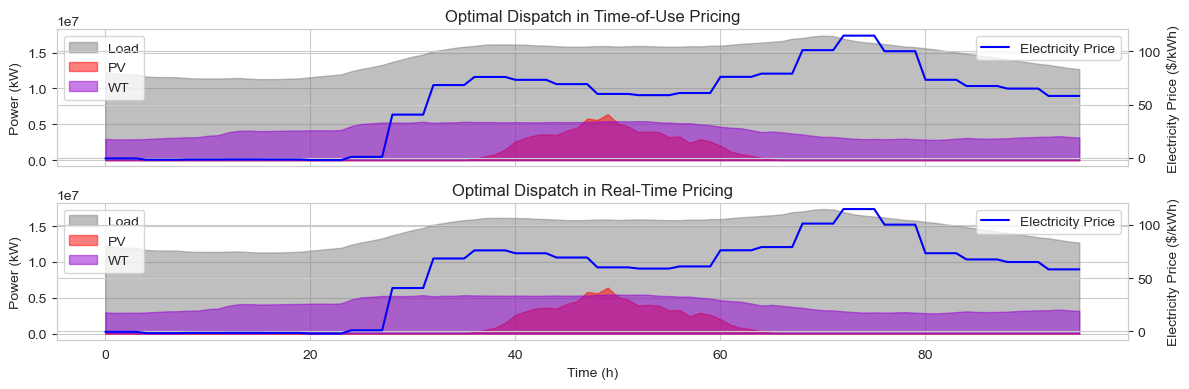

In [12]:
import numpy as np
import matplotlib.pyplot as plt

DAY_NUM = 2

# Extract data for the selected day
pv_data = grid_df[grid_df['day'] == DAY_NUM]["solar (MW)"].to_numpy()*100
wt_data = grid_df[grid_df['day'] == DAY_NUM]["wind (MW)"].to_numpy()
price_data = grid_df[grid_df['day'] == DAY_NUM]["price (EUR/MWh)"].to_numpy()
load_data = grid_df[grid_df['day'] == DAY_NUM]["load (MW)"].to_numpy()
co2_data = grid_df[grid_df['day'] == DAY_NUM]["emission factor (kg CO2/MWh)"].to_numpy()

# Convert MW to kW
pv_data *= 1000
wt_data *= 1000
load_data *= 1000

# Create the index array (1 to 24) for the horizontal axis
t = np.arange(0, len(pv_data))

# Create subplots (one for time-of-use pricing, one for real-time pricing)
fig, axs = plt.subplots(2, 1, figsize=(12, 4), sharex=True)

# Colors for stacked areas
colors = {'PV': 'r', 'WT': 'darkviolet', 'Load': 'gray'}

# First subplot (Time-of-Use Pricing)
axs[0].fill_between(t, load_data, color=colors['Load'], alpha=0.5, label="Load")
axs[0].fill_between(t, pv_data, color=colors['PV'], alpha=0.5, label="PV")
axs[0].fill_between(t, wt_data, color=colors['WT'], alpha=0.5, label="WT")

# Secondary y-axis for electricity price
ax2 = axs[0].twinx()
ax2.plot(t, price_data, color='blue', linestyle='-', linewidth=1.5, label="Electricity Price")

# Labels and titles
axs[0].set_ylabel("Power (kW)")
ax2.set_ylabel("Electricity Price ($/kWh)")
axs[0].set_title("Optimal Dispatch in Time-of-Use Pricing")
axs[0].legend(loc="upper left")
ax2.legend(loc="upper right")

# Second subplot (Real-Time Pricing)
axs[1].fill_between(t, load_data, color=colors['Load'], alpha=0.5, label="Load")
axs[1].fill_between(t, pv_data, color=colors['PV'], alpha=0.5, label="PV")
axs[1].fill_between(t, wt_data, color=colors['WT'], alpha=0.5, label="WT")

# Secondary y-axis for electricity price
ax3 = axs[1].twinx()
ax3.plot(t, price_data, color='blue', linestyle='-', linewidth=1.5, label="Electricity Price")

# Labels and titles
axs[1].set_ylabel("Power (kW)")
ax3.set_ylabel("Electricity Price ($/kWh)")
axs[1].set_xlabel("Time (h)")
axs[1].set_title("Optimal Dispatch in Real-Time Pricing")
axs[1].legend(loc="upper left")
ax3.legend(loc="upper right")

# Formatting and display
plt.tight_layout()
plt.show()


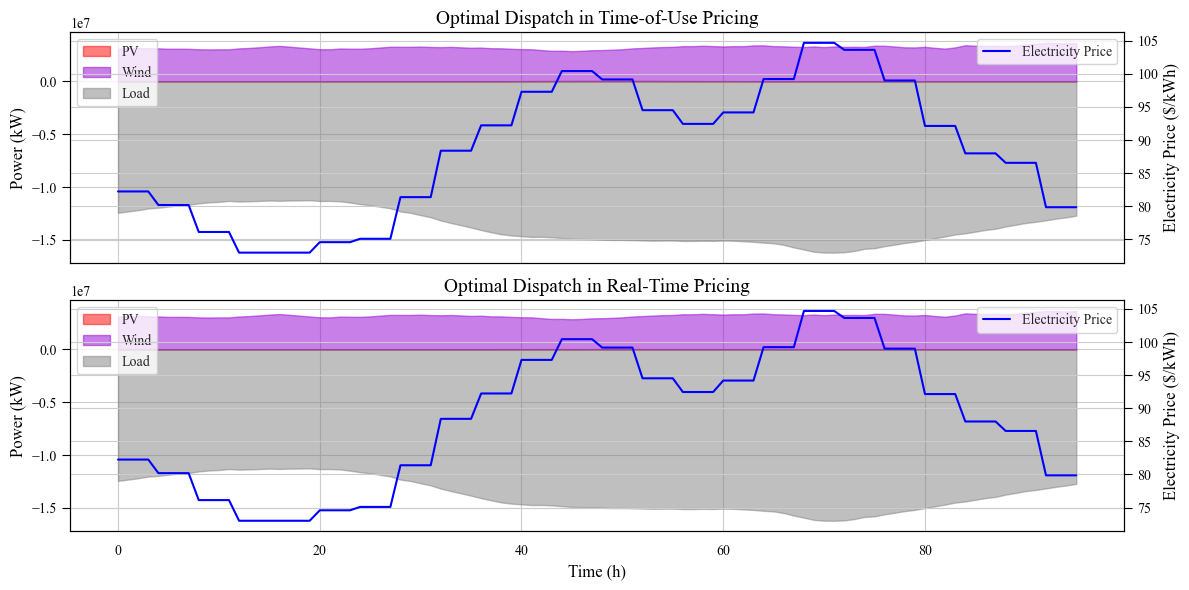

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Set font style to Times New Roman globally
plt.rcParams["font.family"] = "Times New Roman"

DAY_NUM = 5

# Extract data for the selected day
pv_data = grid_df[grid_df['day'] == DAY_NUM]["solar (MW)"].to_numpy()
wt_data = grid_df[grid_df['day'] == DAY_NUM]["wind (MW)"].to_numpy()
price_data = grid_df[grid_df['day'] == DAY_NUM]["price (EUR/MWh)"].to_numpy()
load_data = grid_df[grid_df['day'] == DAY_NUM]["load (MW)"].to_numpy()

# Convert MW to kW
pv_data *= 1000
wt_data *= 1000
load_data *= 1000

# Create the index array (1 to 24) for the horizontal axis
t = np.arange(0, len(pv_data))

# Create subplots (one for time-of-use pricing, one for real-time pricing)
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Define colors
colors = {'PV': 'r', 'WT': 'darkviolet', 'Load': 'gray'}

# Function to format axes
def format_axes(ax, secondary_ax):
    # Make all axes black
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_color('black')
        secondary_ax.spines[spine].set_color('black')

    # Make tick labels black
    ax.tick_params(axis='both', colors='black', direction='out', length=6)  # Major ticks
    # ax.tick_params(axis='x', which='minor', direction='in', length=3, color='black')  # Minor ticks on x-axis
    secondary_ax.tick_params(axis='both', direction='out', length=6, colors='black')

    # Enable minor ticks on x-axis without grid lines
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))  # Minor ticks every 1 hour

# First subplot (Time-of-Use Pricing)
axs[0].fill_between(t, pv_data, color=colors['PV'], alpha=0.5, label="PV")
axs[0].fill_between(t, pv_data + wt_data, pv_data, color=colors['WT'], alpha=0.5, label="Wind")
axs[0].fill_between(t, -load_data, color=colors['Load'], alpha=0.5, label="Load")  # Negative load to represent demand

# Secondary y-axis for electricity price
ax2 = axs[0].twinx()
ax2.plot(t, price_data, color='blue', linestyle='-', linewidth=1.5, label="Electricity Price")

# Formatting
format_axes(axs[0], ax2)
axs[0].set_ylabel("Power (kW)", color='black', fontsize=12)
ax2.set_ylabel("Electricity Price ($/kWh)", color='black', fontsize=12)
axs[0].set_title("Optimal Dispatch in Time-of-Use Pricing", fontsize=14, color='black')
axs[0].legend(loc="upper left", fontsize=10)
ax2.legend(loc="upper right", fontsize=10)

# Second subplot (Real-Time Pricing)
axs[1].fill_between(t, pv_data, color=colors['PV'], alpha=0.5, label="PV")
axs[1].fill_between(t, pv_data + wt_data, pv_data, color=colors['WT'], alpha=0.5, label="Wind")
axs[1].fill_between(t, -load_data, color=colors['Load'], alpha=0.5, label="Load")  # Negative load for demand

# Secondary y-axis for electricity price
ax3 = axs[1].twinx()
ax3.plot(t, price_data, color='blue', linestyle='-', linewidth=1.5, label="Electricity Price")

# Formatting
format_axes(axs[1], ax3)
axs[1].set_ylabel("Power (kW)", color='black', fontsize=12)
ax3.set_ylabel("Electricity Price ($/kWh)", color='black', fontsize=12)
axs[1].set_xlabel("Time (h)", color='black', fontsize=12)
axs[1].set_title("Optimal Dispatch in Real-Time Pricing", fontsize=14, color='black')
axs[1].legend(loc="upper left", fontsize=10)
ax3.legend(loc="upper right", fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


### TimeSeriesDataset

In [89]:
import numpy as np
from sklearn.model_selection import train_test_split

class GridTimeSeriesDataset:
    def __init__(self, dataframe):

        self.dataframe = dataframe
        self.days = np.sort(self.dataframe['day'].unique())  # Unique sorted days
        self.train, self.test = train_test_split(self.days, test_size=0.1, random_state=42)

        # Compute min and max values for normalization
        self.min = dataframe.min()
        self.max = dataframe.max()

    def __len__(self):
        return len(self.days)

    def __getitem__(self, index):
        if index >= len(self.days):
            raise IndexError("Index out of range")

        day = self.days[index]
        day_data = self.dataframe[self.dataframe['day'] == day]

        return {
            'time': np.arange(len(day_data)),  # Time indices
            'solar': day_data['solar (MW)'].to_numpy(dtype=np.float32),
            'wind': day_data['wind (MW)'].to_numpy(dtype=np.float32),
            'load': day_data['load (MW)'].to_numpy(dtype=np.float32),
            'solar_forecast': day_data['solar_forcast (MW)'].to_numpy(dtype=np.float32),
            'wind_forecast': day_data['wind_forecast (MW)'].to_numpy(dtype=np.float32),
            'load_forecast': day_data['load_forecast (MW)'].to_numpy(dtype=np.float32),
            'price': day_data['price (EUR/MWh)'].to_numpy(dtype=np.float32),
            'emission_factor': day_data['emission factor (kg CO2/MWh)'].to_numpy(dtype=np.float32),
        }


# Example Usage:
dataset = GridTimeSeriesDataset(grid_df)
sample = dataset[5]
# print(sample)


### Gym Env

Text(0, 0.5, 'State of Charge (%)')

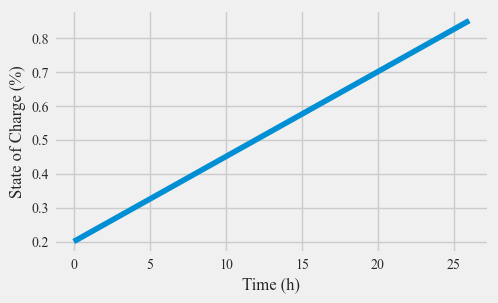

In [90]:
class storage:
    def __init__(self, SOC, dt):
        # Parameters
        self.eta_charge = 1
        self.eta_discharge = 1
        self.Capacity = 40 # kWh
        # Constraints
        self.Pbatt_max = 4 # kW
        self.SOC_min = 0.2
        self.SOC_max = 0.85
        # Variables
        self.SOC = np.clip(SOC, self.SOC_min, self.SOC_max)
        self.dt = dt

    def update(self, Pbatt):
        self.SOC += (self.eta_charge/self.Capacity)*np.maximum(0, Pbatt)*self.dt +\
                    (1/self.eta_discharge/self.Capacity)*min(0, Pbatt)*self.dt
        return self.SOC


test_battery = storage(SOC=0.2, dt=1)
SOC_PLOT = [test_battery.SOC]

while test_battery.SOC<test_battery.SOC_max:
    Pbatt = 1
    test_battery.update(Pbatt)

    SOC_PLOT.append(test_battery.SOC)

plt.figure(figsize=(5,3))
plt.plot(SOC_PLOT)
plt.grid(True)
plt.xlabel('Time (h)')
plt.ylabel('State of Charge (%)')

In [91]:
# Define the dictionary
DG_coeffs = {
    "MT": {
        "Pmin": 6,  # kW
        "Pmax": 30, # kW
        "b" : 4.37, # €/kWh
        "c": 85.06, # €/h
        "ef": 724.6/1000,# kg/kWh
        "Type": "Microturbine"
    },
    "FC": {
        "Pmin": 3,   # kW
        "Pmax": 30,  # kW
        "b": 2.84,   # €/kWh
        "c": 255.18, # €/h
        "ef": 489.4/1000, # kg/kWh
        "Type": "FC"
    },
    "WT": {
        "Pmin": 0,  # kW
        "Pmax": 15, # kW
        "b": 10.63, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Wind Turbine"
    },
    "PV1": {
        "Pmin": 0,  # kW
        "Pmax": 3,  # kW
        "b": 54.84, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Photovoltaic 1"
    },
    "PV2": {
        "Pmin": 0 , # kW
        "Pmax": 10, # kW
        "b": 54.84, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Photovoltaic 2"
    }
}

# Print the dictionary
pprint(DG_coeffs)

{'FC': {'Pmax': 30,
        'Pmin': 3,
        'Type': 'FC',
        'b': 2.84,
        'c': 255.18,
        'ef': 0.4894},
 'MT': {'Pmax': 30,
        'Pmin': 6,
        'Type': 'Microturbine',
        'b': 4.37,
        'c': 85.06,
        'ef': 0.7246},
 'PV1': {'Pmax': 3,
         'Pmin': 0,
         'Type': 'Photovoltaic 1',
         'b': 54.84,
         'c': 0,
         'ef': 0},
 'PV2': {'Pmax': 10,
         'Pmin': 0,
         'Type': 'Photovoltaic 2',
         'b': 54.84,
         'c': 0,
         'ef': 0},
 'WT': {'Pmax': 15,
        'Pmin': 0,
        'Type': 'Wind Turbine',
        'b': 10.63,
        'c': 0,
        'ef': 0}}


In [92]:
import gymnasium as gym
import numpy as np

class MicroGridEnv(gym.Env):
    def __init__(self, grid_df, DG_coeffs):
        super(MicroGridEnv, self).__init__()
        
        self.day = 0  # Start at the first day
        self.t = 0
        self.dt = 0.25  # Time step (hours)
        self.MAX_STEP = 24 * (1 / self.dt)  # Number of time steps in a day

        self.timeseries = GridTimeSeriesDataset(grid_df)
        self.DG_coeffs = DG_coeffs
        self.battery = storage(SOC=0.5, dt=self.dt)

        self.PGmax = 200
        self.PBmax = self.battery.Pbatt_max
        self.bigM = 1

        self.Bi = [v["b"] for v in DG_coeffs.values()]
        self.Ci = [v["c"] for v in DG_coeffs.values()]
        self.EFi = [v["ef"] for v in DG_coeffs.values()]

        # Get min/max values from the dataset for normalization
        self.data_min = grid_df.min()
        self.data_max = grid_df.max()

        # Define action space: [-1,1] mapped to actual power ranges
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(3,), dtype=np.float32)
        # Define observation space: Normalize relevant state variables to [-1,1]
        self.observation_space = gym.spaces.Box(low=-1, high=1, shape=(7,), dtype=np.float32)

        self.memory = {'power': [], 'storage': []}


    def normalize(self, value, min_val, max_val):
        return 2 * (value - min_val) / (max_val - min_val) - 1


    def denormalize(self, value, min_val, max_val):
        return (value + 1) / 2 * (max_val - min_val) + min_val


    def step(self, action):
        # Get the time-series data for the current day
        day_data = self.timeseries[self.day]

        Pbatt = self.denormalize(action[0], -self.PBmax, self.PBmax)
        Pgi = [
            self.denormalize(action[1], list(self.DG_coeffs.values())[0]['Pmin'], list(self.DG_coeffs.values())[0]['Pmax']),
            self.denormalize(action[2], list(self.DG_coeffs.values())[1]['Pmin'], list(self.DG_coeffs.values())[1]['Pmax'])
        ]
        
        # Get time-series values
        DEMAND = day_data['load'][self.t]
        BG = day_data['price'][self.t]
        EFG = day_data['emission_factor'][self.t]
        WIND = day_data['wind'][self.t]
        PV = day_data['solar'][self.t]

        self.battery.update(Pbatt)

        Pgi_all = np.hstack([Pgi, [WIND, PV, PV]])
        PG = -(Pgi_all.sum() - Pbatt - DEMAND)
        
        Power_Cost = np.sum(self.Bi[:2] * Pgi_all[:2] + self.Ci[:2]) + (BG * PG)
        Env_Cost = np.sum(self.EFi[:2] * Pgi_all[:2]) + (EFG * PG)

        PG_constraint = np.maximum(0, PG - self.PGmax) + np.maximum(0, -self.PGmax - PG)

        Battery_constraint = np.clip(self.battery.SOC - self.battery.SOC_max, 0, np.inf) + \
                             np.clip(self.battery.SOC_min - self.battery.SOC, 0, np.inf)
        
        reward = -(Power_Cost + 1e-2 * Env_Cost) / 1e5 - self.bigM * (PG_constraint + 20 * Battery_constraint)
        
        self.t += 1  # Move to the next time step
        done = self.t >= self.MAX_STEP  # End episode if all time steps are completed
        
        # Get next state
        next_DEMAND = day_data['load'][self.t] if not done else 0
        next_BG = day_data['price'][self.t] if not done else 0
        next_EFG = day_data['emission_factor'][self.t] if not done else 0
        next_PV = day_data['solar'][self.t] if not done else 0
        next_WIND = day_data['wind'][self.t] if not done else 0

        next_state = np.array([
            self.normalize(self.t, 0, self.MAX_STEP),
            self.normalize(next_DEMAND, self.data_min['load (MW)'], self.data_max['load (MW)']),
            self.normalize(next_WIND, self.data_min['wind (MW)'], self.data_max['wind (MW)']),
            self.normalize(next_PV, self.data_min['solar (MW)'], self.data_max['solar (MW)']),
            self.normalize(next_BG, self.data_min['price (EUR/MWh)'], self.data_max['price (EUR/MWh)']),
            self.normalize(next_EFG, self.data_min['emission factor (kg CO2/MWh)'], self.data_max['emission factor (kg CO2/MWh)']),
            self.normalize(self.battery.SOC, 0, 1)
        ])

        self.memory['power'].append(np.hstack([PG, Pbatt, Pgi, [WIND, PV, PV]]))
        self.memory['storage'].append(self.battery.SOC)
        
        info = {'NEXT DEMAND': DEMAND, 'Power_Cost': Power_Cost, 'Env_Cost': Env_Cost}
        return next_state.astype(np.float32), reward, done, False, info

    def reset(self, test=False):
        self.t = 0
        self.battery = storage(SOC=0.5, dt=self.dt)
        self.day = np.random.choice(self.timeseries.test) if test else np.random.choice(self.timeseries.train)

        day_data = self.timeseries[self.day]

        DEMAND = day_data['load'][self.t]
        BG = day_data['price'][self.t]
        EFG = day_data['emission_factor'][self.t]
        WIND = day_data['wind'][self.t]
        PV = day_data['solar'][self.t]

        state = np.array([
            self.normalize(self.t, 0, self.MAX_STEP),
            self.normalize(DEMAND, self.data_min['load (MW)'], self.data_max['load (MW)']),
            self.normalize(WIND, self.data_min['wind (MW)'], self.data_max['wind (MW)']),
            self.normalize(PV, self.data_min['solar (MW)'], self.data_max['solar (MW)']),
            self.normalize(BG, self.data_min['price (EUR/MWh)'], self.data_max['price (EUR/MWh)']),
            self.normalize(EFG, self.data_min['emission factor (kg CO2/MWh)'], self.data_max['emission factor (kg CO2/MWh)']),
            self.normalize(self.battery.SOC, 0, 1)
        ])
        
        self.memory['power'] = []
        self.memory['storage'] = []
        
        info = {'DEMAND': DEMAND, 'Power_Cost': 0, 'Env_Cost': 0}
        return state.astype(np.float32), info

    def render(self):
        return 0

# Example Usage
env = MicroGridEnv(grid_df, DG_coeffs)
env.action_space, env.observation_space, env.reset(), env.step(np.ones(4,))

(Box(-1.0, 1.0, (3,), float32),
 Box(-1.0, 1.0, (7,), float32),
 (array([-1.        , -0.4752513 , -0.02324884, -1.        , -0.4370713 ,
         -0.08279666,  0.        ], dtype=float32),
  {'DEMAND': 11798.0, 'Power_Cost': 0, 'Env_Cost': 0}),
 (array([-0.9791667 , -0.5152665 , -0.01514924, -1.        , -0.4370713 ,
         -0.08279666,  0.05      ], dtype=float32),
  -8278.822303528008,
  False,
  False,
  {'NEXT DEMAND': 11798.0,
   'Power_Cost': 864496.54,
   'Env_Cost': 1773381.2800769042}))

## RL code

#### Models

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.distributions import Normal

device = "cuda" if torch.cuda.is_available() else "cpu"

# Gaussian Policy Network architecture
class GaussianPolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims):
        super().__init__()
        # Build hidden layers
        layers = []
        input_dim = state_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.LeakyReLU())
            input_dim = hidden_dim
        self.hidden_layers = nn.Sequential(*layers)
        
        # Output layers for mean and standard deviation
        self.fc_mean = nn.Linear(input_dim, action_dim)
        self.fc_log_std = nn.Linear(input_dim, action_dim)

    def forward(self, state):
        x = self.hidden_layers(state)
        action_mean = self.fc_mean(x)
        action_log_std = torch.clamp(self.fc_log_std(x), min=-10, max=2)  # Adjusted range
        action_std = torch.exp(action_log_std)
        return action_mean, action_std

    def select_action(self, state, deterministic=False):
        mean, std = self(state)
        if deterministic: 
            action = torch.tanh(mean)  # Directly apply tanh for deterministic mode
            log_prob = torch.zeros_like(mean).sum(dim=-1, keepdim=True)
        else:
            normal_dist = Normal(mean, std)
            action_pre_tanh = normal_dist.rsample()  # Sample before applying tanh
            log_prob = normal_dist.log_prob(action_pre_tanh).sum(dim=-1, keepdim=True)
            
            # Apply tanh transformation correctly
            action = torch.tanh(action_pre_tanh)
            # Log probability correction for tanh squashing
            log_prob -= torch.log(1 - action.pow(2) + 1e-6).sum(dim=-1, keepdim=True)
        return action, log_prob


# Q-Network architecture
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims):
        super().__init__()
        # Build hidden layers from the list of hidden dimensions
        layers = []
        input_dim = state_dim + action_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.LeakyReLU())
            input_dim = hidden_dim
        self.hidden_layers = nn.Sequential(*layers)
        
        # Output layer for Q-value
        self.fc_out = nn.Linear(input_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        x = self.hidden_layers(x)
        q_value = self.fc_out(x)
        return q_value

#### Agent

In [86]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from utils.asset import map_to_range, np_to_torch, torch_to_np
from utils.buffer import ReplayBuffer
from utils.plot import plot_return
from utils.logger import TensorboardWriter

device = "cuda" if torch.cuda.is_available() else "cpu"

class SACAgent():
    def __init__(self, state_size, action_size, action_range, hidden_dim=[128], 
                 alpha=0.1, gamma=0.99, lr=3e-4, tau=0.005, buffer_size=1e5, batch_size=256):
        self.state_size = state_size
        self.action_size = action_size
        self.action_range = action_range
        self.gamma = gamma
        self.lr = lr
        self.tau = tau
        self.batch_size = batch_size
        self.memory = ReplayBuffer(int(buffer_size))

        # Trainable entropy temperature
        self.target_entropy = -action_size  # A heuristic for continuous action spaces
        self.log_alpha = torch.tensor(np.log(alpha), requires_grad=True, device=device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=self.lr)

        # Actor (policy)
        self.actor = GaussianPolicyNetwork(state_size, action_size, hidden_dim).to(device)

        # Critics
        self.QNet1 = QNetwork(state_size, action_size, hidden_dim).to(device)
        self.target_QNet1 = QNetwork(state_size, action_size, hidden_dim).to(device)
        self.target_QNet1.load_state_dict(self.QNet1.state_dict())

        self.QNet2 = QNetwork(state_size, action_size, hidden_dim).to(device)
        self.target_QNet2 = QNetwork(state_size, action_size, hidden_dim).to(device)
        self.target_QNet2.load_state_dict(self.QNet2.state_dict())

        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.lr, weight_decay=1e-4)
        self.QNet1_optimizer = optim.Adam(self.QNet1.parameters(), lr=self.lr, weight_decay=1e-4)
        self.QNet2_optimizer = optim.Adam(self.QNet2.parameters(), lr=self.lr, weight_decay=1e-4)

        # Logging
        self.writer = TensorboardWriter(log_dir="Logs/SAC_Q", comment="SAC_Q")
        self.iter = 0
        self.best_avg_reward = -np.inf

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample from replay buffer
        states, actions, action_log_probs, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert data to PyTorch tensors
        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.float32).to(device)
        action_log_probs = torch.tensor(action_log_probs, dtype=torch.float32).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)

        # Compute Q targets
        with torch.no_grad():
            next_actions, next_action_log_probs = self.actor.select_action(next_states)
            alpha = self.log_alpha.exp()  # Convert log_alpha to alpha
            q_values_next = torch.min(self.target_QNet1(next_states, next_actions), 
                                      self.target_QNet2(next_states, next_actions)) - alpha * next_action_log_probs
            q_targets = rewards + (self.gamma * q_values_next * (1 - dones))

        q_targets = q_targets.detach()

        # Update Q1
        q1_values = self.QNet1(states, actions)
        Q1_loss = F.mse_loss(q1_values, q_targets)
        self.QNet1_optimizer.zero_grad()
        Q1_loss.backward()
        self.QNet1_optimizer.step()

        # Update Q2
        q2_values = self.QNet2(states, actions)
        Q2_loss = F.mse_loss(q2_values, q_targets)
        self.QNet2_optimizer.zero_grad()
        Q2_loss.backward()
        self.QNet2_optimizer.step()

        # Compute actor loss
        actions, action_log_probs = self.actor.select_action(states)
        actor_loss = -(torch.min(self.QNet1(states, actions), self.QNet2(states, actions)) - alpha * action_log_probs).mean()

        # Update actor network
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update alpha (train entropy)
        alpha_loss = -self.log_alpha * (action_log_probs + self.target_entropy).detach().mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()

        # Log loss values
        self.writer.log_scalar("Loss/Actor", actor_loss, self.iter)
        self.writer.log_scalar("Loss/Q1", Q1_loss, self.iter)
        self.writer.log_scalar("Loss/Q2", Q2_loss, self.iter)
        self.writer.log_scalar("Loss/Alpha", alpha_loss, self.iter)
        self.writer.log_scalar("Param/Alpha", alpha, self.iter)
        self.iter += 1

        # Soft update of target networks
        for target_param, param in zip(self.target_QNet1.parameters(), self.QNet1.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for target_param, param in zip(self.target_QNet2.parameters(), self.QNet2.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


    def evaluate(self, env):
        state, _ = env.reset(test=True)
        done = False
        episode_reward = 0
        while not done:
            # Use the policy to select an action (without exploration)
            state_t = np_to_torch(state).to(device)
            action_t, _ = self.actor.select_action(state_t, deterministic=True)
            action = torch_to_np(action_t)
            mapped_action = map_to_range(action, self.action_range)
            next_state, reward, done, _, _ = env.step(mapped_action)
            episode_reward += reward
            state = next_state

        if episode_reward > self.best_avg_reward:
            self.best_avg_reward = episode_reward
            torch.save(self.actor.state_dict(), "Logs/SAC_Q_best_actor.pth")
            print(f"New best model saved with average reward: {self.best_avg_reward}")

    def train(self, env, episodes):
        returns = []
        for episode in range(episodes):
            score = 0
            length = 0
            done = False
            state, _ = env.reset()
            while not done:
                # convert to tensor
                state_t = np_to_torch(state).to(device)
                # select action
                action_t, action_log_prob_t = self.actor.select_action(state_t)
                # convert to numpy
                action = torch_to_np(action_t)
                action_log_prob = torch_to_np(action_log_prob_t)
                # map action to range
                mapped_action = map_to_range(action, self.action_range)
                # take action
                next_state, reward, done, _, info = env.step(mapped_action)
                # store in memory
                self.memory.push([state, action, action_log_prob, reward, next_state,  done])
                # train agent
                self.learn()
                state = next_state
                score += reward
                length += 1
            # log episode info
            self.writer.log_scalar("Episode/Return", score, episode)
            self.writer.log_scalar("Episode/Length", length, episode)
            # store episode return
            returns.append(score)
            # plot_return(returns, f'Soft Actor Critic (SAC) ({device})')
            # Evaluation
            if (episode + 1) % 20 == 0: self.evaluate(env)
        env.close()
        self.writer.close()
        return returns


#### Training

In [87]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
action_max = env.action_space.high

env = MicroGridEnv(grid_df, DG_coeffs)
agent = SACAgent(state_size, action_size, action_range=[env.action_space.low, env.action_space.high], hidden_dim=[256,256], buffer_size=1e5)
result = agent.train(env, episodes=100000)

New best model saved with average reward: -1129355.474890586
New best model saved with average reward: -989305.7773459171
New best model saved with average reward: -954127.3979804252


KeyboardInterrupt: 

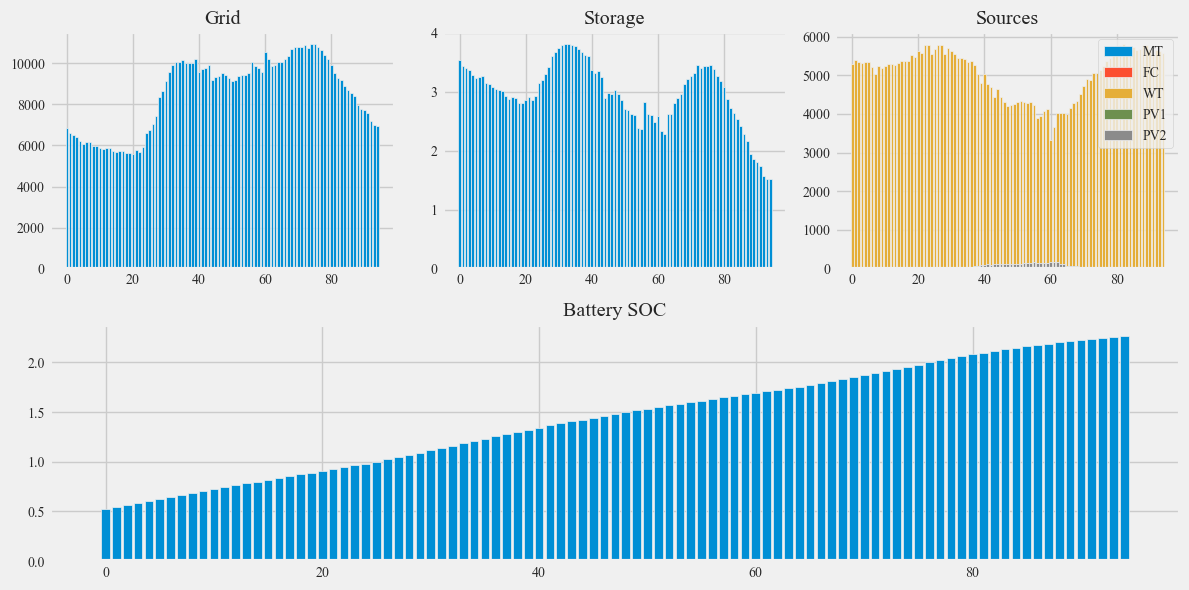

-802307.9877342178


In [88]:
import torch
from utils.asset import map_to_range, np_to_torch, torch_to_np
device = "cuda" if torch.cuda.is_available() else "cpu"

agent.actor.load_state_dict(torch.load("Logs/SAC_Q_best_actor.pth", weights_only=True))

state,_ = env.reset(test=True)

grid_results = []
rewards = []
actions = []

done = False
while not done:
    grid_results = np.array(env.memory['power'])
    battery_results = np.array(env.memory['storage'])

    # convert to tensor
    state_t = np_to_torch(state).to(device)
    # select action
    action_t, action_log_prob_t = agent.actor.select_action(state_t, deterministic=True)
    # convert to numpy
    action = torch_to_np(action_t)
    action_log_prob = torch_to_np(action_log_prob_t)
    # map action to range
    mapped_action = map_to_range(action, agent.action_range)
    # take action

    next_state, reward, done, _, info = env.step(mapped_action)
    
    state = next_state
    rewards.append(reward)

plt.figure(figsize=(12,6))
plt.subplot(2,3,1)
plt.bar(range(len(grid_results[:,0])), grid_results[:,0])
plt.title('Grid')
plt.subplot(2,3,2)
plt.bar(range(len(grid_results[:,1])), grid_results[:,1])
plt.title('Storage')
plt.subplot(2,3,3)
for i in range(grid_results[:,2:].shape[1]):
    plt.bar(range(len(grid_results)), grid_results[:,2+i], label=list(env.DG_coeffs.keys())[i])
plt.legend()
plt.title('Sources')
plt.subplot(2,1,2)
plt.bar(range(len(battery_results)), battery_results)
plt.title('Battery SOC')
plt.tight_layout()
plt.show()

print(sum(rewards))